In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle


# SimPEG imports
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.utils import plot_1d_layer_model
from discretize import TensorMesh


# SBI imports
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis


# SimPeg Forward Model

## Forward Simulation - Textbook example
## Log Spacing 

In [2]:
# Define the 'a' spacing for Schlumberger array measurements for each reading
number_of_measurements=20
a_b_electrode_separations_log = np.logspace(0.1, 3, number_of_measurements)
m_n_electrode_separations_log = 0.01 * a_b_electrode_separations_log 

source_list_log = []  # create empty array for sources to live

for ab, mn in zip(a_b_electrode_separations_log, m_n_electrode_separations_log):


    # AB electrode locations for source. Each is a (1, 3) numpy array
    A_location = np.r_[-ab, 0.0, 0.0]
    B_location = np.r_[ab, 0.0, 0.0]

    # MN electrode locations for receivers. Each is an (N, 3) numpy array
    M_location = np.r_[-mn, 0.0, 0.0]
    N_location = np.r_[mn, 0.0, 0.0]

    # Create receivers list. Define as pole or dipole.
    receiver_list = dc.receivers.Dipole(
        M_location, N_location, data_type="apparent_resistivity"
    )
    receiver_list = [receiver_list]

    # Define the source properties and associated receivers
    source_list_log.append(dc.sources.Dipole(receiver_list, A_location, B_location))

# Define survey
survey_log = dc.Survey(source_list_log)

electrode_separations = 0.5 * np.sqrt(
    np.sum((survey_log.locations_a - survey_log.locations_b) ** 2, axis=1)
)

In [3]:
# Define layer thicknesses.
layer_thicknesses = np.r_[5.0, 10.0]

# Define layer resistivities.
model = np.r_[500, 200, 50]

# Define mapping from model to 1D layers.
model_map = maps.IdentityMap(nP=len(model))

In [4]:
simulation = dc.simulation_1d.Simulation1DLayers(
    survey=survey_log,
    rhoMap=model_map,
    thicknesses=layer_thicknesses,
)

# Predict data for a given model
dpred_log_spacing = simulation.dpred(model)

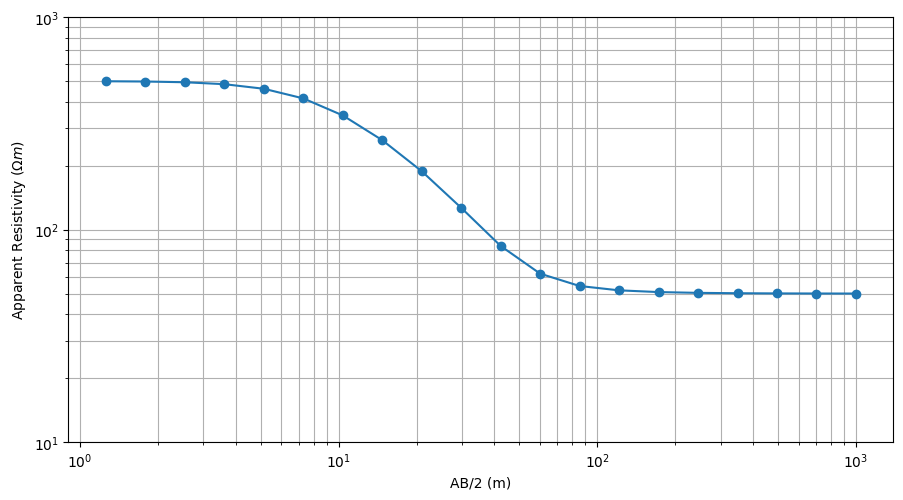

In [5]:
# Plot apparent resistivities on sounding curve# Plot apparent resistivities on sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax1.loglog(a_b_electrode_separations_log, dpred_log_spacing, marker='o', label="$50 \Omega m$) lower unit")
ax1.set_ylim([10, 1000])
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
plt.grid(True, which="both", ls="-")
plt.show()



## Forward Model - Linear Spacing

In [6]:
# Define the 'a' spacing for Schlumberger array measurements for each reading
number_of_measurements= 20
# get 20 measurements in the area between 1 to 100, as this is the area of resistivity change and another 20 measurements from 100 to 1000 
# Note like this the value 100 is included double once from the first and once from the second list
a_b_electrode_separations_lin = np.concatenate((np.linspace(1,100,number_of_measurements),np.linspace(100, 1000, number_of_measurements)), axis=None)
m_n_electrode_separations_lin = 0.01 * a_b_electrode_separations_lin

source_list_lin = []  # create empty array for sources to live

for ab, mn in zip(a_b_electrode_separations_lin, m_n_electrode_separations_lin):


    # AB electrode locations for source. Each is a (1, 3) numpy array
    A_location = np.r_[-ab, 0.0, 0.0]
    B_location = np.r_[ab, 0.0, 0.0]

    # MN electrode locations for receivers. Each is an (N, 3) numpy array
    M_location = np.r_[-mn, 0.0, 0.0]
    N_location = np.r_[mn, 0.0, 0.0]

    # Create receivers list. Define as pole or dipole.
    receiver_list = dc.receivers.Dipole(
        M_location, N_location, data_type="apparent_resistivity"
    )
    receiver_list = [receiver_list]

    # Define the source properties and associated receivers
    source_list_lin.append(dc.sources.Dipole(receiver_list, A_location, B_location))

# Define survey
survey_lin = dc.Survey(source_list_lin)

electrode_separations_lin = 0.5 * np.sqrt(
    np.sum((survey_lin.locations_a - survey_lin.locations_b) ** 2, axis=1)
)

In [7]:
# Define layer thicknesses.
layer_thicknesses = np.r_[5.0, 10.0]

# Define layer resistivities.
model = np.r_[500, 200, 50]

# Define mapping from model to 1D layers.
model_map = maps.IdentityMap(nP=len(model))

In [8]:
# Define the simulation
simulation = dc.simulation_1d.Simulation1DLayers(
    survey=survey_lin,
    rhoMap=model_map,
    thicknesses=layer_thicknesses,
)

# Predict data for a given model
dpred_lin_spacing = simulation.dpred(model)

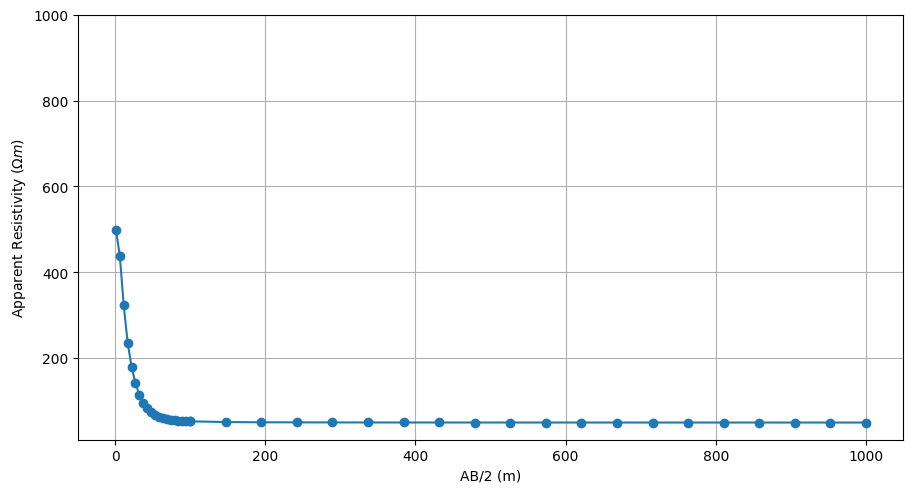

In [9]:
# Plot apparent resistivities on sounding curve# Plot apparent resistivities on sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax1.plot(a_b_electrode_separations_lin, dpred_lin_spacing, marker='o', label="$50 \Omega m$) lower unit")
ax1.set_ylim([10, 1000])
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
plt.grid(True, which="both", ls="-")
plt.show()


# Inversion of Sounding Data - Textbook example
## SimPEG - Least Squares 1D Inversion

In [10]:
std = 0.02 * np.abs(dpred_lin_spacing)
data_object = data.Data(survey_lin, dobs=dpred_lin_spacing, standard_deviation=std)

In [11]:
# Define layer thickness
layer_thicknesses =  np.r_[5,10]
#layer_thicknesses =  np.logspace(0, 0.3, 10)
#layer_thicknesses =  np.linspace(1, 15, 10)

# Define a mesh for plotting and regularization.
mesh = TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], "0")

In [12]:
# Define model. A resistivity (Ohm meters) or conductivity (S/m) for each layer. - here each layer gets the same resistivity assigned
starting_model = np.log(2e2 * np.ones((len(layer_thicknesses) + 1)))  

# Define mapping from model to active cells.
model_map = maps.IdentityMap(nP=len(starting_model)) * maps.ExpMap()

In [13]:
# Define the physics of the problem using the Simulation1DLayers class.
simulation = dc.simulation_1d.Simulation1DLayers(
    survey=survey_lin,
    rhoMap=model_map,
    thicknesses=layer_thicknesses,
)

In [14]:
# Use L2 norm for data misfit of the weighted residual between observed and predicted
l2_data_misfit = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

# Define the regularization (model objective function)
reg = regularization.WeightedLeastSquares(
    mesh, alpha_s=1.0, alpha_x=1.0, reference_model=starting_model
)

# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.InexactGaussNewton(maxIter=30, maxIterCG=20)


# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(l2_data_misfit, reg, opt)

In [15]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Set the rate of reduction in trade-off parameter (beta) each time
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off parameter value.
beta_schedule = directives.BetaSchedule(coolingFactor=5.0, coolingRate=3.0)

# Apply and update sensitivity weighting as the model updates
update_sensitivity_weights = directives.UpdateSensitivityWeights()

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# The directives are defined as a list.
directives_list = [
    update_sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
]

In [16]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run the inversion
recovered_model = inv.run(starting_model)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayers problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  9.80e+04  3.10e+05  0.00e+00  3.10e+05    7.78e+05      0              
   1  9.80e+04  1.05e+05  7.83e-01  1.82e+05    7.60e+04      0              
   2  9.80e+04  1.19e+05  6.06e-01  1.79e+05    1.38e+04      0              
   3  1.96e+04  1.16e+05  6.38e-01  1.29e+05    2.74e+05      0              
   4  1.96e+04  3.12e+04  2.75e+00  8.51e+04    2.08e+04      0              
   5  1.96e+04  3.72e+04  2.42e+00  8.47e+04    6.61e+03      0              
   6  3.92e+03  3.53e+04  2.52e+00

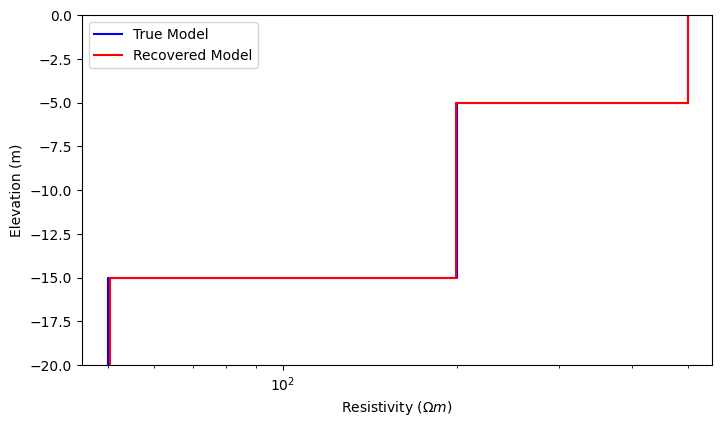

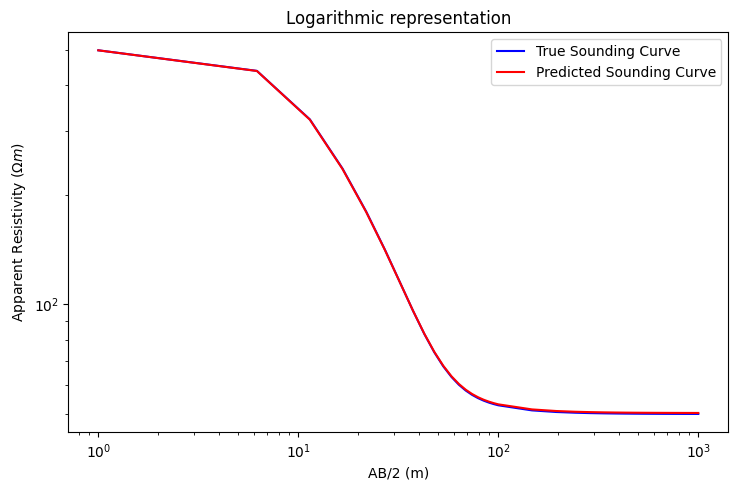

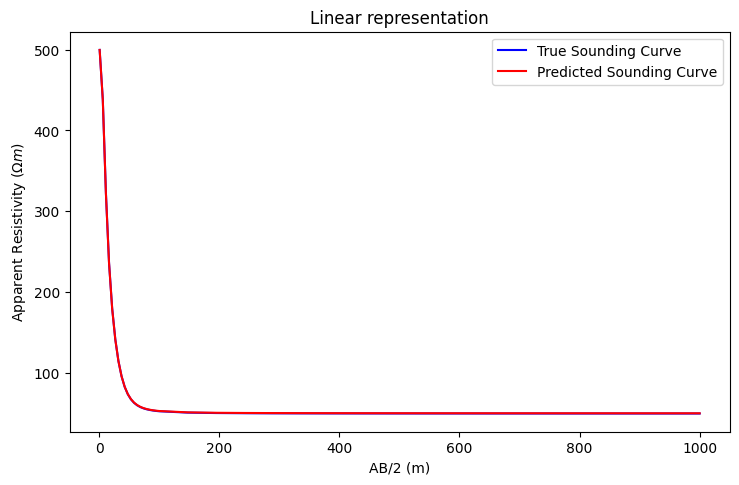

In [17]:
# Define true model and layer thicknesses
true_model = np.r_[500, 200, 50]
true_thickness = np.r_[5.0, 10.0]

# Plot true model and recovered model
fig = plt.figure(figsize=(9, 5))
x_min = np.min([np.min(model_map * recovered_model), np.min(model)])
x_max = np.max([np.max(model_map * recovered_model), np.max(model)])

ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
plot_1d_layer_model(true_thickness, true_model, ax=ax1, plot_elevation=True, color="b")
plot_1d_layer_model(
    layer_thicknesses,
    model_map * recovered_model,
    ax=ax1,
    plot_elevation=True,
    color="r",
)
ax1.set_xlabel(r"Resistivity ($\Omega m$)")
ax1.set_xlim(0.9 * x_min, 1.1 * x_max)
ax1.set_ylim(-20, 0)
ax1.legend(["True Model", "Recovered Model"])

# Plot the true and apparent resistivities on a sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.8])
ax1.loglog(electrode_separations_lin, dpred_lin_spacing, "b")
ax1.loglog(electrode_separations_lin, inv_prob.dpred, "r")
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend(["True Sounding Curve", "Predicted Sounding Curve"])
plt.title("Logarithmic representation")
plt.show()

# Plot the true and apparent resistivities on a sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.8])
ax1.plot(electrode_separations_lin, dpred_lin_spacing, "b")
ax1.plot(electrode_separations_lin, inv_prob.dpred, "r")
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend(["True Sounding Curve", "Predicted Sounding Curve"])
plt.title("Linear representation")
plt.show()

## SBI for Inversion - Textbook example 
#### Fix models thicknesses and only infer the resistivities


#### Wrapper for forward model - also inferring layer's thicknesses

In [18]:
# Note parameters are composed of resistivities and thicknesses - in that order. First resistivities then thicknesses
def dc_forward(params, survey=survey_log):
    
    # Split params into resistivities and thicknesses
    param_length = len(params)
    number_of_layers = int((param_length+1)/2)
    # First half of parameters is resistivities
    resistivities = params[:number_of_layers]
    # Second half of parameters are thicknesses
    thicknesses = params[number_of_layers:]
    
    # Define mapping from model to 1D layers.
    model_map = maps.IdentityMap(nP=len(resistivities))
    simulation = dc.simulation_1d.Simulation1DLayers(
        survey=survey,
        rhoMap=model_map,
        thicknesses=thicknesses,
    )
    
    # Predict data for a given model
    pred = simulation.dpred(resistivities)
    return pred

#### Wrapper for forward model - fixed layer's thicknesses (here textbook example [5,10])

In [28]:
# Note parameters are composed of resistivities and thicknesses - in that order. First resistivities then thicknesses
def dc_forward_fixed_resistivities(params, survey=survey_lin):

    # First half of parameters is resistivities
    resistivities = params
    thicknesses = np.r_[5,10]
    
    # Define mapping from model to 1D layers.
    model_map = maps.IdentityMap(nP=len(resistivities))
    simulation = dc.simulation_1d.Simulation1DLayers(
        survey=survey,
        rhoMap=model_map,
        thicknesses=thicknesses,
    )
    
    # Predict data for a given model
    pred = simulation.dpred(resistivities)
    return pred

In [29]:
num_dim = 3
prior_min = torch.as_tensor([0,0,0])
prior_max = torch.as_tensor([5000,5000,5000])

# Define the prior as a BoxUniform distribution
prior = utils.BoxUniform(low=-prior_min * torch.ones(num_dim), high=prior_max * torch.ones(num_dim))

# Define the prior and the simulator for sampling based on the wrapped forward model and the prior
simulator, prior = prepare_for_sbi(dc_forward_fixed_resistivities, prior)

In [30]:
# Initialise an SNPE inference object
inference = SNPE(prior=prior, device="cpu", show_progress_bars=True)
# Simulate the forward model num_simulations many times from the wraped forward model and the prior
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [31]:
# Pass the simulated data in pairs of parameters theta and simulated data x to the inference object
inference = inference.append_simulations(theta, x)

In [32]:
# Train the inference object
density_estimator = inference.train()

 Neural network successfully converged after 352 epochs.

In [33]:
posterior = inference.build_posterior(density_estimator)

In [34]:
posterior_samples = posterior.sample((10000,), x=dpred_lin_spacing)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

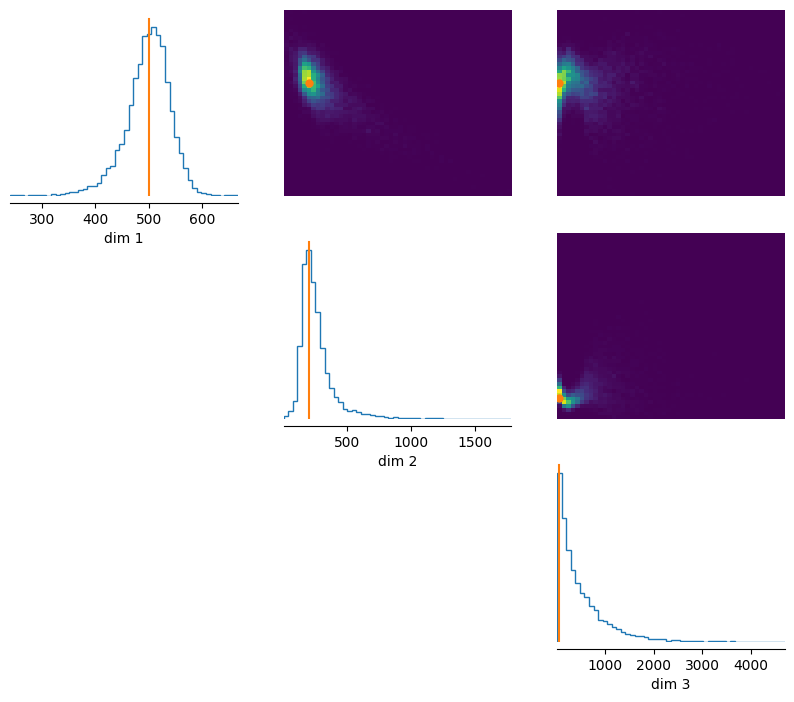

In [35]:
# plot Posterior samples
_ = analysis.pairplot(posterior_samples,points= torch.tensor([500,200, 50]), figsize=(10,8))

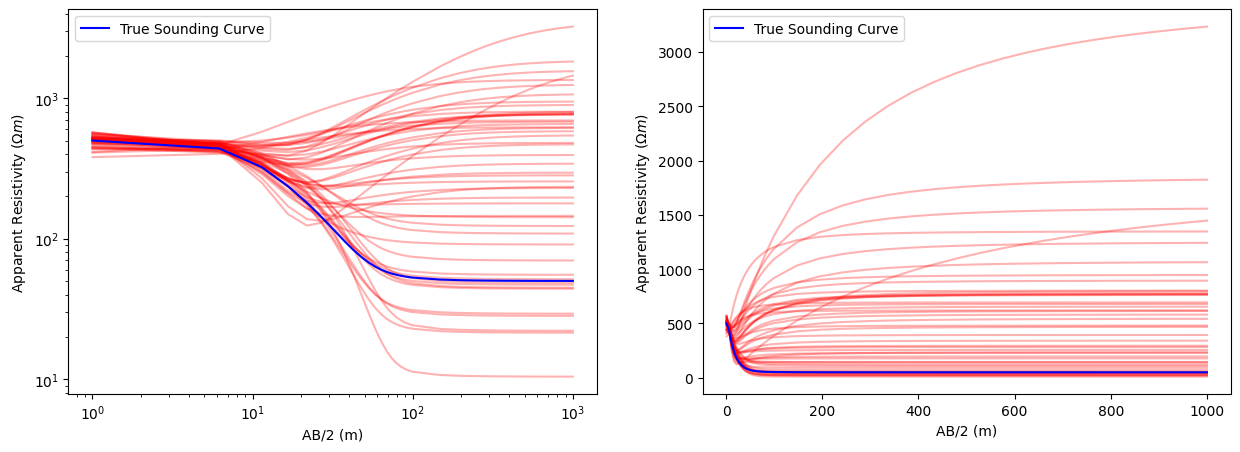

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
for i in range(50):
    posterior_sample = posterior_samples[i]
    
    app_res = dc_forward_fixed_resistivities(np.array(posterior_sample))
    ax1.loglog(electrode_separations_lin, app_res, "r", alpha=0.3)
    ax2.plot(electrode_separations_lin, app_res, "r", alpha=0.3)
    
ax1.loglog(electrode_separations_lin, dpred_lin_spacing, "b", label="True Sounding Curve")
ax2.plot(electrode_separations_lin, dpred_lin_spacing, "b", label="True Sounding Curve")

ax1.set_xlabel("AB/2 (m)")
ax2.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax2.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend()
ax2.legend()
plt.show()


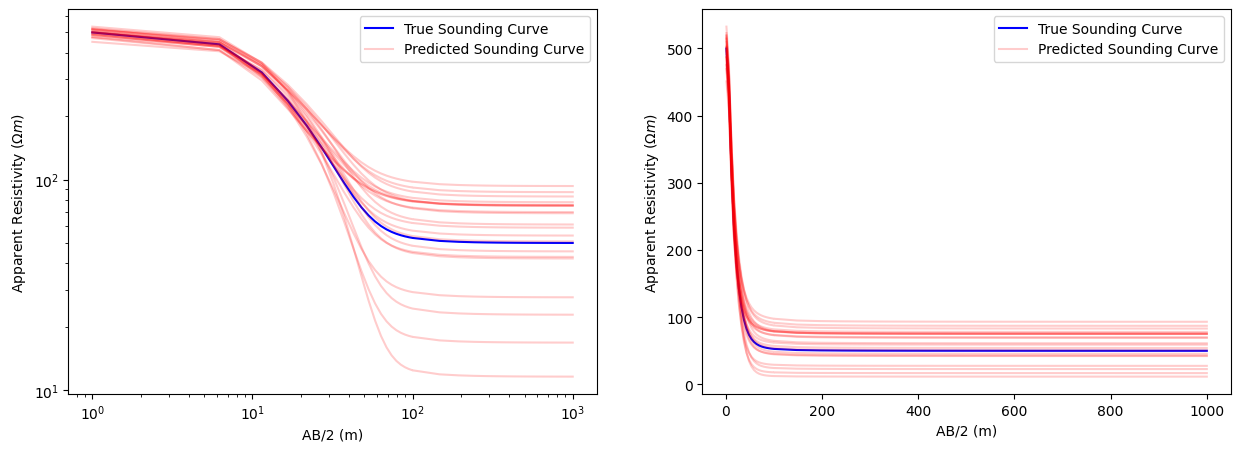

In [41]:
# Plot individual sounding curves from the derived posterior samples

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.loglog(electrode_separations_lin, dpred_lin_spacing, "b")
ax2.plot(electrode_separations_lin, dpred_lin_spacing, "b")

num_good_samples = 0
apparent_resistivities = []
while num_good_samples <= 20:
    i = np.random.randint(10000)
    posterior_sample = posterior_samples[i]
    first_res = posterior_sample[0]
    second_res = posterior_sample[1]
    third_res = posterior_sample[2]
    if(450 <= first_res <= 550
        and 150 <= second_res <= 250
        and 10 <= third_res <= 100):
        num_good_samples += 1
        app_res = dc_forward_fixed_resistivities(np.array(posterior_sample))
        apparent_resistivities.append(app_res)
        ax1.loglog(electrode_separations_lin, app_res, "r", alpha=0.2)
        ax2.plot(electrode_separations_lin, app_res, "r", alpha=0.2)

ax1.set_xlabel("AB/2 (m)")
ax2.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax2.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend(["True Sounding Curve", "Predicted Sounding Curve"])
ax2.legend(["True Sounding Curve", "Predicted Sounding Curve"])
plt.show()


## Attempt to increase the amount of measurements taken for the initial sounding curves

#### Step 1 - Generate the sounding examples for 100 measurements



In [49]:
# Define the 'a' spacing for Schlumberger array measurements for each reading
number_of_measurements=100
a_b_electrode_separations = np.logspace(0.1, 3, number_of_measurements)
m_n_electrode_separations_lin = 0.01 * a_b_electrode_separations 

source_list_lin = []  # create empty array for sources to live

for ab, mn in zip(a_b_electrode_separations, m_n_electrode_separations_lin):


    # AB electrode locations for source. Each is a (1, 3) numpy array
    A_location = np.r_[-ab, 0.0, 0.0]
    B_location = np.r_[ab, 0.0, 0.0]

    # MN electrode locations for receivers. Each is an (N, 3) numpy array
    M_location = np.r_[-mn, 0.0, 0.0]
    N_location = np.r_[mn, 0.0, 0.0]

    # Create receivers list. Define as pole or dipole.
    receiver_list = dc.receivers.Dipole(
        M_location, N_location, data_type="apparent_resistivity"
    )
    receiver_list = [receiver_list]

    # Define the source properties and associated receivers
    source_list_lin.append(dc.sources.Dipole(receiver_list, A_location, B_location))

# Define survey
survey_lin = dc.Survey(source_list_lin)

electrode_separations = 0.5 * np.sqrt(
    np.sum((survey_lin.locations_a - survey_lin.locations_b) ** 2, axis=1)
)

In [50]:
# Define layer thicknesses.
layer_thicknesses = np.r_[5.0, 10.0]

# Define layer resistivities.
model = np.r_[500, 200, 50]
params = np.r_[model, layer_thicknesses]

dpred_100 = dc_forward(params, survey_lin)


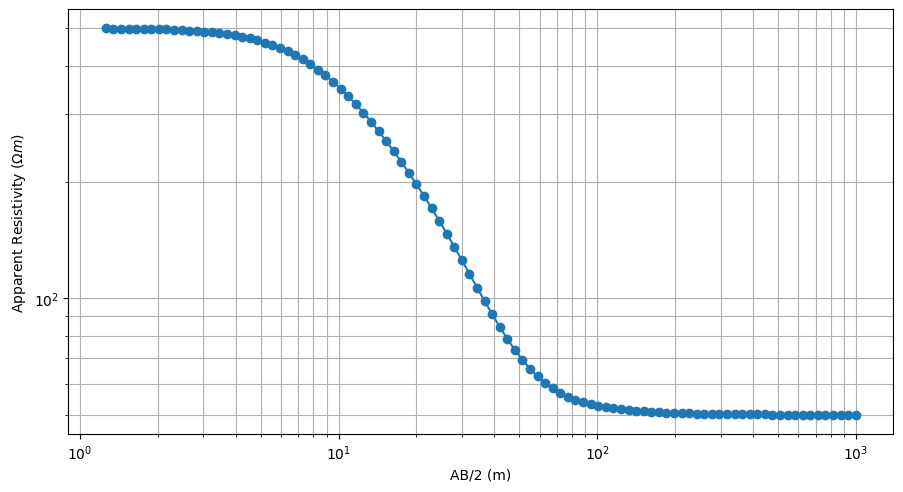

In [51]:
# Plot apparent resistivities on sounding curve# Plot apparent resistivities on sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax1.loglog( a_b_electrode_separations, dpred_100, marker='o', label="$50 \Omega m$) lower unit")
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
plt.grid(True, which="both", ls="-")
plt.show()


In [55]:
num_dim = 3
prior_min = torch.as_tensor([0, 0, 0 ])
prior_max = torch.as_tensor([5000, 5000, 5000 ])

prior = utils.BoxUniform(low=-prior_min * torch.ones(num_dim), high=prior_max * torch.ones(num_dim))


In [56]:
simulator, prior = prepare_for_sbi(dc_forward_fixed_resistivities, prior)
inference = SNPE(prior=prior, device="cpu", show_progress_bars=True)
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=10000)

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

In [58]:
with open("pickle/sbi_models/theta_10000_simulations.pkl", "wb") as input:
    pickle.dump(theta, input)
    
with open("pickle/sbi_models/x_10000_simulations.pkl", "wb") as input:
    pickle.dump(x, input)

In [60]:
inference = inference.append_simulations(theta, x)

In [61]:
density_estimator = inference.train()

 Neural network successfully converged after 92 epochs.

In [63]:
posterior = inference.build_posterior(density_estimator)
posterior_samples = posterior.sample((100000,), x=dpred_100)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [83]:
with open("pickle/sbi_models/posterior_10000_simulations_resistivities_only.pkl", "wb") as input:
    pickle.dump(posterior, input)
    

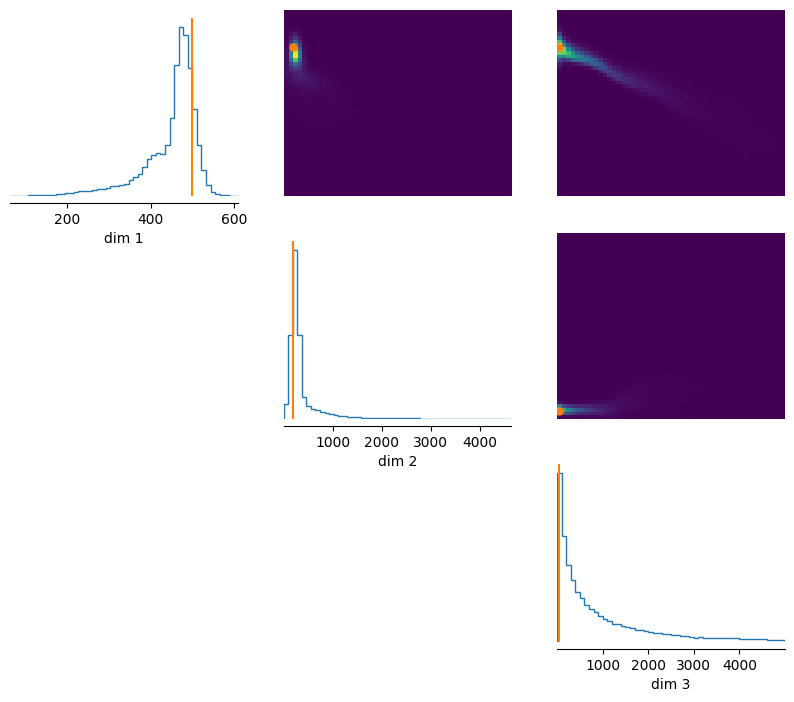

In [65]:
# plot Posterior samples
_ = analysis.pairplot(posterior_samples, points=torch.tensor([500, 200, 50]), figsize=(10, 8))

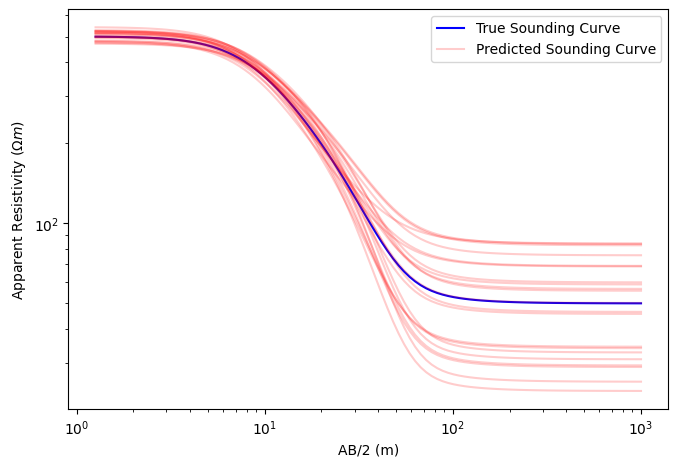

In [82]:
# Plot individual sounding curves from the derived posterior samples
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.8])
ax1.loglog(electrode_separations, dpred_100, "b")

num_good_samples = 0
apparent_resistivities = []
while num_good_samples <= 20:
    i = np.random.randint(100000)
    posterior_sample = posterior_samples[i]
    first_res = posterior_sample[0]
    second_res = posterior_sample[1]
    third_res = posterior_sample[2]
    if(450 <= first_res <= 550
        and 150 <= second_res <= 250
        and 10 <= third_res <= 100):
        num_good_samples += 1
        app_res = dc_forward_fixed_resistivities(np.array(posterior_sample))
        apparent_resistivities.append(app_res)
        ax1.loglog(electrode_separations, app_res, "r", alpha=0.2)

ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend(["True Sounding Curve", "Predicted Sounding Curve"])
plt.show()


In [ ]:
# Less observations - e.g. 20 
# Try to make them evenly spaced np.linspace instead of logspace
# Try to limit in terms of std. 
# Heavy tails might come from too many observations - e.g. same for the penguine example

In [43]:
# Normalizing the parameters s.t. they are in the range of 0 -1 and then multiply them by 5000 later
# What should the actual posterior look like? - Like how narrow should they be?
# if it is very narrow in terms of 100 then we only have 20 good simulations for 1000 training samples 1/50 from 1000 thats around 20 simulations that are actually good
# In that case then one might need to run more simulations
# Where do the 5000 resistivity prior actually come from? - Check again online and talk to Reinhard as well about it .
# Add noise to the model - more noise for higher resistiviesl